*<center><h1><b>Computer Assignment 2</b></h1>*
*<h3>Narges Sadat Seyed Haeri</h3></center>*
*<center><h3>SID : 810100165</h3></center>*

### *Problem Description*
*In this problem, we have a dataset containing audio samples. Using Hidden Markov Model (HMM), we aim to train a model on this dataset to classify each audio sample and subsequently analyze the model's performance. The classification process relies on extracting Mel-Frequency Cepstral Coefficients (MFCC) from each audio, as MFCCs provide valuable information for classification tasks in audio processing.*



### *Goal*
*This notebook aims to educate on Hidden Markov Models (HMMs) and their application in sound classification. We will explore how to utilize features extracted from audio data for this purpose.*

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from hmmlearn import hmm
from python_speech_features import mfcc
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.stats import multivariate_normal
import numpy as np
import os

## *Preprocess*

In [2]:
speakers = ['lucas', 'george', 'jackson', 'theo', 'nicolas', 'yweweler']
digits = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
target_frame_length = 30
folder_path = "recordings"
num_repetitions = 50  # Each speaker says each digit 50 times
energy_threshold = 0 

### *Question 1:*
*In the process of developing our model, we have utilized a dataset consisting of six speakers, each repeating the same digit fifty times. This results in a total of 300 data points. The feature extraction method employed is the Mel Frequency Cepstral Coefficients (MFCC), which is a popular choice for speech recognition tasks due to its ability to capture the power spectrum of the speech signal and mimic the logarithmic perception of loudness and pitch of the human auditory system.*

*One might question the absence of a segmentation process in our preprocessing steps. However, in our specific case, segmentation was not necessary. This is because each spoken digit by each speaker is a distinct, complete unit of sound. This is a stark contrast to continuous speech recognition tasks, where segmentation is required to break down the continuous speech into individual words or phonemes.*

*Furthermore, the Hidden Markov Model (HMM) used in our model is particularly adept at handling sequences, such as the sequence of MFCCs that represent a spoken digit. HMMs can accommodate variations in speed and tone of speech by modeling the probability of transitioning from one state (e.g., a particular part of a spoken digit) to another.*

*In conclusion, the absence of segmentation in our preprocessing steps is justified by the nature of our data, the robustness of MFCCs for speech recognition, and the suitability of HMMs for this task.*


### *Question 2:*

*MFCC (Mel-Frequency Cepstral Coefficients):*

- *Usage: MFCCs are widely used in speech and audio processing for feature extraction.*
- *Characteristics: They capture the essential characteristics of the audio signal by representing the short-term power spectrum of sound.*
- *Derivation: MFCCs are derived from the Fourier Transform of the log power spectrum of the audio signal, followed by the Discrete Cosine Transform (DCT).*
- *Representation: The resulting coefficients represent the spectral envelope of the audio signal in a compact form, focusing on perceptually relevant features.*
- *Robustness: MFCCs are robust to variations in speaker identity, background noise, and channel effects.*

*Zero Crossing Rate:*

- *Usage: Zero Crossing Rate (ZCR) is a simple yet effective feature used in audio signal processing.*
- *Representation: It represents the rate at which the audio signal changes its sign (crosses zero).*
- *Relation: ZCR is related to the frequency content and periodicity of the audio signal.*
- *Indication: Higher ZCR values indicate more high-frequency content or noise in the signal, while lower values suggest smoother or periodic signals.*
- *Applications: ZCR is often used in speech and music analysis tasks, such as voice activity detection or musical onset detection.*

*Spectrogram-Mel:*

- *Representation: Mel spectrogram is a representation of the power spectral density of an audio signal in the mel scale.*
- *Mel Scale: The mel scale is a perceptual scale of pitches based on the human auditory system's response to frequency.*
- *Information: Mel spectrograms capture both the spectral and temporal information of the audio signal and are useful for extracting features relevant to human auditory perception.*
- *Applications: They are commonly used in speech recognition and music information retrieval tasks.*

*Chroma Features:*

- *Representation: Chroma features represent the distribution of pitch classes (or chroma) in an audio signal.*
- *Derivation: They are derived from the short-time Fourier Transform (STFT) of the audio signal, followed by mapping the magnitude spectrum onto the 12 pitch classes of the Western musical scale.*
- *Information: Chroma features provide information about the harmonic content and tonal characteristics of the audio signal.*
- *Applications: Chroma features are commonly used in music analysis tasks, such as chord recognition, genre classification, and melody extraction.*
- *Robustness: They are robust to changes in timbre and dynamics, making them suitable for analyzing polyphonic music signals.*

*Relationships between these features:*

- *MFCCs and Chroma: MFCCs and chroma features are often used together in music analysis tasks. While MFCCs capture spectral envelope information, chroma features focus on harmonic content and tonal characteristics.*
- *Spectrogram-Mel and MFCCs: Spectrogram-Mel and MFCCs are closely related, as MFCCs are derived from the mel spectrogram by applying additional processing steps such as the Discrete Cosine Transform (DCT).*
- *Zero Crossing Rate: Zero Crossing Rate can provide complementary information to spectral features such as MFCCs and chroma, as it reflects the temporal characteristics of the audio signal, especially for percussive sounds or speech segments.*

In [3]:
def calc_mfcc(speaker, digit):
    mfccs_list = []
    for i in range(num_repetitions):

        audio_file = os.path.join(folder_path, f"{digit}_{speaker}_{i}.wav")
        sampling_rate, audio = wavfile.read(audio_file)

        # Remove silence
        non_silent_indices = np.where(audio > energy_threshold)[0]
        if len(non_silent_indices) > 0:
            audio = audio[non_silent_indices[0]:non_silent_indices[-1] + 1]

        mfcc_features = mfcc(audio, samplerate=sampling_rate, nfft=1024, winlen = 0.03)

        # Pad MFCC features if necessary
        num_frames = mfcc_features.shape[0]

        if num_frames < target_frame_length:
            padding = np.zeros((target_frame_length - num_frames, mfcc_features.shape[1]))
            mfcc_features = np.concatenate((mfcc_features, padding))

        mfcc_features = mfcc_features[:target_frame_length, :]
        mfccs_list.append(mfcc_features)

    return mfccs_list


def mfcc_heatmap(title, mfccs_array):
    plt.matshow(np.rot90(mfccs_array[0]), cmap='Spectral', origin='upper', aspect='auto')
    plt.title(f"{title} MFCC Heatmap")
    plt.xlabel('Time')
    plt.ylabel('Coefficients')
    plt.colorbar()
    plt.show()

### *Question 3:*

*Robustness and Sensitivity of MFCC Features:*

- *Noise Robustness: MFCCs are relatively robust to background noise and other forms of interference, as they are derived from the logarithmic spectrum of the audio signal, which emphasizes important spectral features while attenuating less relevant components.*
  
- *Temporal Robustness: MFCCs capture both short-term and long-term spectral characteristics of audio signals, making them suitable for analyzing signals with temporal variations. They are robust to slight variations in signal duration and temporal alignment, which is beneficial for tasks involving continuous speech or music signals.*

- *Frequency Sensitivity: MFCCs are sensitive to changes in the frequency content of audio signals, particularly in the critical frequency regions important for human perception. They can accurately capture variations in pitch, formants, and other spectral features related to the timbre and identity of sound sources.*
  
- *Dynamic Sensitivity: MFCCs are sensitive to dynamic changes in the spectral envelope of audio signals, such as transitions between different phonemes in speech or changes in musical articulation. They can capture rapid spectral changes and provide insight into the dynamics of sound production and perception.*

- *Parameter Sensitivity: The effectiveness of MFCCs can be influenced by the choice of parameters such as the number of filterbanks, the size of the analysis window, and the number of cepstral coefficients. Sensitivity to parameter settings requires careful tuning to ensure optimal performance across different types of sound signals and applications.*

### *Question 4:*

*The efficacy of MFCCs may be influenced by:*

- *Noisy Environments: MFCCs can be sensitive to background noise. In noisy environments, the noise can interfere with the speech signal and affect the extracted MFCC features, leading to less accurate speech recognition.*

- *Speaker Variability: While MFCCs are designed to be robust to different speakers, extreme variability in speech, such as accents, speech disorders, or extreme pitch variations, can affect the performance of MFCCs.*

- *Emotional Variations: MFCCs may not perform as well when there are significant emotional variations in the speech. Emotions can affect the pitch, speed, and intensity of speech, which can in turn affect the MFCC features.*

- *Non-Speech Sounds: MFCCs are designed for speech signals and may not perform as well with non-speech sounds, such as music or environmental sounds.*

- *Low Resource Languages: For languages that are under-resourced and lack sufficient training data, the performance of MFCCs can be affected due to the lack of data to capture the full variability of the language.*

- * It's important to note that many of these challenges can be mitigated with additional preprocessing steps, such as noise reduction, or by combining MFCCs with other features or models that can handle these variations.*

### *Question 5:*
*Overlapping frames are used in the computation of MFCCs to ensure continuity and preserve information between frames.*

*Audio signals change over time and these changes can be abrupt or subtle. If we were to simply divide the signal into non-overlapping frames, we might miss these changes, especially if they occur at the boundaries between frames.By using overlapping frames, we ensure that these changes are captured. The overlap allows for a smoother transition between frames and helps to maintain the continuity of the signal, which is particularly important for capturing phenomena like formants and pitches in speech and music signals.*



### *Question 6:*

*Using fewer frames for computing MFCCs can help reduce computational complexity because the initial MFCCs capture important details about the sound's pitch and energy distribution. Focusing on the first 12 or 13 MFCCs helps extract essential information while keeping things simple and efficient. Studies show that people are more sensitive to these lower-order MFCCs, making them especially important for getting all the important details from the sound.*

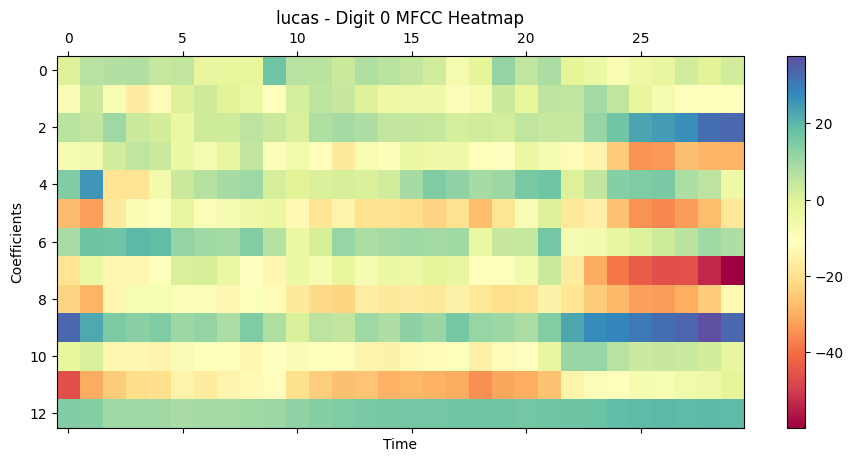

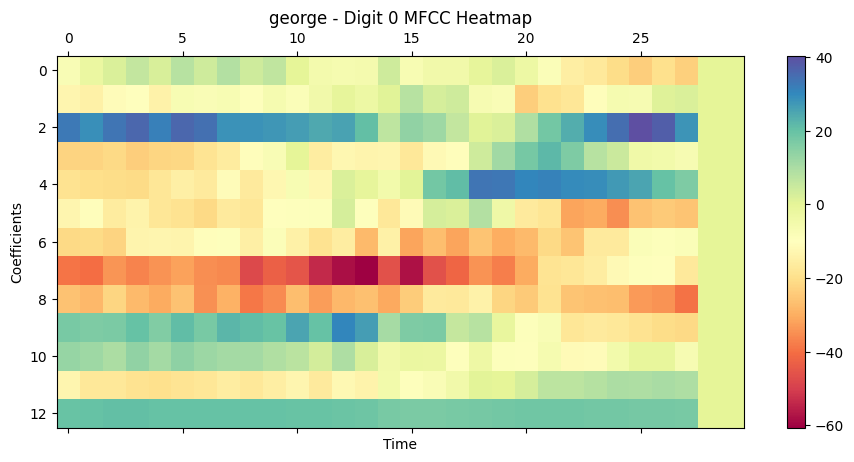

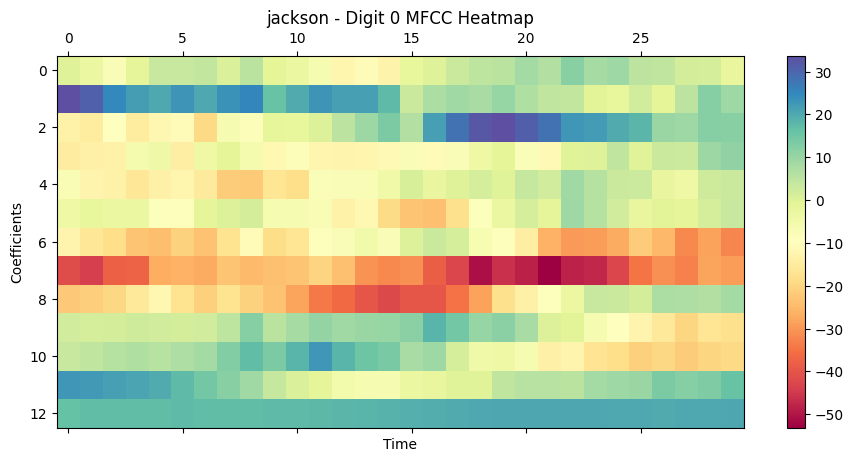

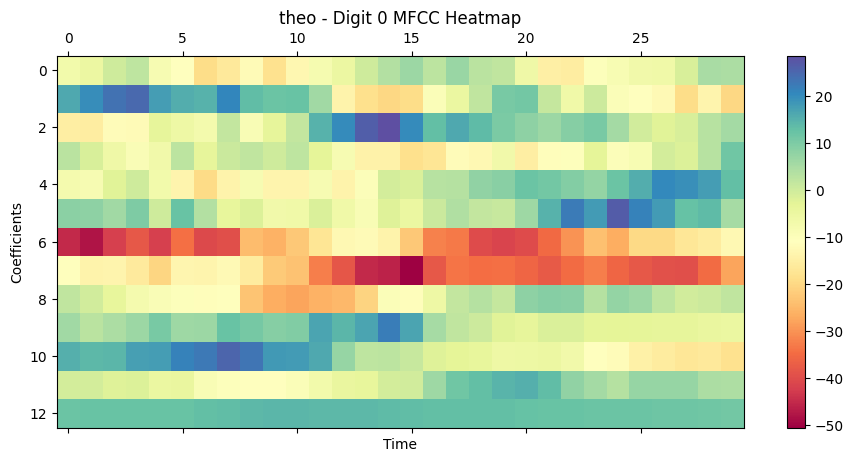

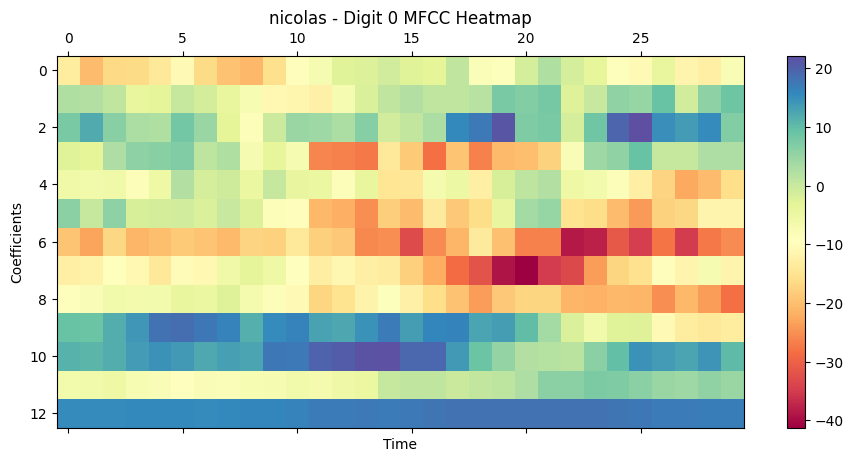

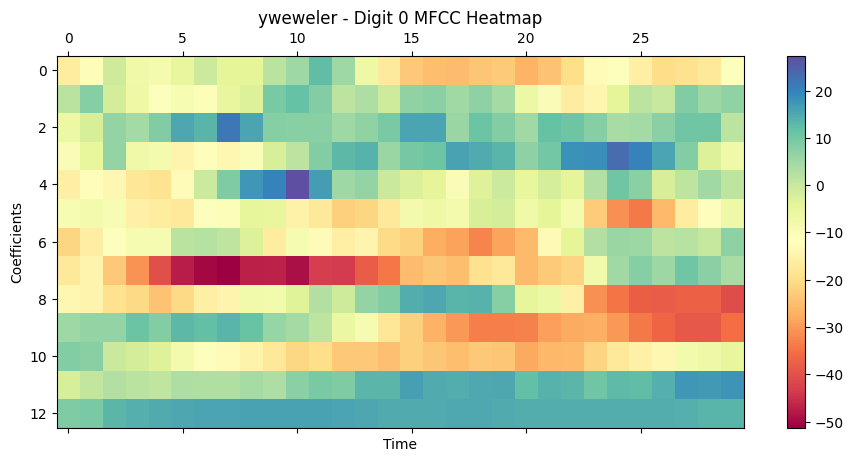

In [4]:
total_mfccs_digits = []
total_samples_digits = []

total_mfccs_speaker = []
total_samples_speaker = []


for i, digit in enumerate(digits):
    mfcc_array_of_speaker = []
    for speaker in speakers:
        mfccs_array = calc_mfcc(speaker, digit)
        mfcc_array_of_speaker.extend(mfccs_array) 
    total_mfccs_digits.append(mfcc_array_of_speaker)
    total_samples_digits.append([i] * len(mfcc_array_of_speaker))
  

for i, speaker in enumerate(speakers):
    mfcc_array_of_speaker = []
    for digit in digits:
        mfccs_array = calc_mfcc(speaker, digit)
        if digit == '0':
            mfcc_heatmap(f"{speaker} - Digit {digit}",mfccs_array)
        mfcc_array_of_speaker.extend(mfccs_array)
        
    total_mfccs_speaker.append(mfcc_array_of_speaker)
    total_samples_speaker.append([i] * len(mfcc_array_of_speaker))


## *Introduction to HMM*

### *Question 1:*

*In this scenario, the "states" represent some features of the audio. It actually keeps track of more complex features than the initially calculated ones, and it is somehow a combination of them.In HMM used for speech recognition, each state typically represents a certain part of the speech signal.* 

*For example,in digit recognition, each state could represent a certain phoneme (the smallest unit of sound) in the pronunciation of the digit. The transitions between states would then represent the progression of sounds in the digit's pronunciation.*

*in speaker recognition, each state could represent a certain characteristic of the speaker's voice, such as a particular pitch or tone. The transitions between states would then represent the changes in these characteristics over time.*

*or each state could be thought of as representing a certain pattern of frequencies that the speaker tends to produce.*

*the states in an HMM are "hidden", meaning they're not directly observable from the data. Instead, they're inferred from the observed data (the MFCCs in our case) using the training algorithm.*

*The "observations" are the visible states or features that are familiar to us. In this model setup, observations consist of the audio characteristics extracted by MFCC, which serve as the input data for the model.*

### *Question 2:*

*A first-order HMM, also known as a first-order Markov model, assumes that the probability of transitioning to any particular state depends only on the current state and not on the sequence of states that preceded it.* 
*In contrast, a higher-order HMM considers dependencies on the current and one or more previous states when determining the  transition probabilities. The higher-order models can capture more complex dependencies in the sequence of states.*

### *Question 3:*

*Hidden Markov Models are probabilistic models that are particularly well-suited for analyzing and modeling phenomena characterized by sequential data and underlying hidden states. They are useful when working with sequential data like a series of events or a time series. They are good at capturing the relationships between these events and can help us understand how things change over time.*
*Examples of HMM's application:*

- *Natural Language Processing:  HMMs can model the sequential nature of language and capture the dependencies between different words. Words in a sentence are treated as observable emissions, and underlying grammatical structures are represented by hidden states.*

- *Speech Recognition: HMMs are widely employed in speech recognition systems. The speech signal is modeled as a sequence of hidden states, and each state emits observable features. HMMs can effectively model the variability in speech patterns and account for the temporal nature of spoken language.*

- *Bioinformatics:They can model biological sequences as sequences of hidden states and capture dependencies between adjacent elements.*

### *Question 4:*
*Pros*: 
- *HMMs provide a probabilistic framework for modeling sequential data and it can capture the uncertainities and so the model is more robust.*
- it can capture sequential dependencies in data. so it is useful for time-series data analysis.
- *HMMs can handle missing data . using the forward-backward algorithm which can estimate the probability distribution of missing states or observations.*
- *HMMs provide a compact representation of the system so it is beneficial for computational resources.*

*Cons*: 
- *HMMs assume that the observations are conditionally independent given the hidden states. This assumption may not be correct in some real-world scenario.*
- *fixed state space in HMMs can limit the model ability to handle situations where the number or nature of states may change.*
- *HMMs are sensitive to the choice of initial parameters and incorrect initialization may result in convergence to suboptimal.*
- *The model forget the past states as the sequence length increases which can limit its effectiveness in tasks that need a long-term memory.*

### *Question 5:*
1. *discrete HMM: In a discrete HMM the hidden states and the observations are discrete variables. this means that the hidden states have a finite set of values and the observations also belong to a discrete set. DHMMs are mostly used in applications such as part-of-speech tagging.*

2. *continuous HMM: In a continuous HMM the observations are continuous variables and mostly modeled by probability density functions such as Gaussian distribution. CHMMs are often used in applications involving continuous data, such as speech recognition where features are represented as continuous variables.*

3. *left to right HMM : In this type the model transitions from one state to the next in a fixed left to right order. this type of HMM is useful when the process has a temporal ordering and the system evolves in a sequential manner.*

4. *Factorial: Introduces a factorial structure in the emission probabilities, allowing dependencies between different elements of the observation vector.*

In [5]:
data_test_x_digit = []
data_test_y_digit = []
DS_train_digits=dict()

for i in range(len(digits)):
    x_train, x_test, y_train, y_test = train_test_split(np.array(total_mfccs_digits[i]), np.array(total_samples_digits[i]), test_size=0.3, random_state=247)
    DS_train_digits[digits[i]] = x_train.reshape((x_train.shape[0] * x_train.shape[1], x_train.shape[2]))
    data_test_x_digit.append(list(x_test))
    data_test_y_digit.append(y_test)

data_test_x_digit = np.array(data_test_x_digit)
data_test_x_digit = data_test_x_digit.reshape((data_test_x_digit.shape[0] * data_test_x_digit.shape[1], data_test_x_digit.shape[2], data_test_x_digit.shape[3]))
data_test_y_digit = np.array(data_test_y_digit).flatten()

In [6]:
data_test_x_speakers = []
data_test_y_speakers = []
DS_train_speakers=dict()

for i in range(len(speakers)):
    x_train, x_test, y_train, y_test = train_test_split(np.array(total_mfccs_speaker[i]), np.array(total_samples_speaker[i]), test_size=0.3, random_state=42)
    DS_train_speakers[speakers[i]] = x_train.reshape((x_train.shape[0] * x_train.shape[1], x_train.shape[2]))
    data_test_x_speakers.append(list(x_test))
    data_test_y_speakers.append(y_test)

data_test_x_speakers = np.array(data_test_x_speakers)
data_test_x_speakers = data_test_x_speakers.reshape((data_test_x_speakers.shape[0] * data_test_x_speakers.shape[1], data_test_x_speakers.shape[2], data_test_x_speakers.shape[3]))
data_test_y_speakers = np.array(data_test_y_speakers).flatten()

## *Implementing HMM using library*


*Training a Hidden Markov Model (HMM) for recognizing digits:*

In [7]:
digit_HMM_models=[]
library_y_predictions_digits=[]
for digit in digits:
    model = hmm.GaussianHMM(n_components=12, covariance_type='diag')
    model.fit(DS_train_digits[digit])
    digit_HMM_models.append(model)

for i in range(data_test_x_digit.shape[0]):
    scores=[]
    for model in digit_HMM_models:
        scores.append(model.score(data_test_x_digit[i,:]))
    label = np.argmax(np.array(scores))
    library_y_predictions_digits.append(label)

*Training a Hidden Markov Model (HMM) for recognizing speakers:*

In [8]:
speakers_HMM_models=[]
library_y_predictions_speakers=[]
for speaker in speakers:
    model = hmm.GaussianHMM(n_components=12, covariance_type='diag')
    model.fit(DS_train_speakers[speaker])
    speakers_HMM_models.append(model)

for i in range(data_test_x_speakers.shape[0]):
    scores=[]
    for model in speakers_HMM_models:
        scores.append(model.score(data_test_x_speakers[i,:]))
    label = np.argmax(np.array(scores))
    library_y_predictions_speakers.append(label)

In [9]:
def confusion_matrix(y, y_pred, num_of_classes):
    confusion_matrix = np.zeros((num_of_classes, num_of_classes))
    for i in range(num_of_classes):
        for j in range(num_of_classes):
            confusion_matrix[i, j] = (
                np.sum((y == i) & (y_pred == j)))/(len(y)/num_of_classes)
    return confusion_matrix

def plot_conf_matrix(conf_matrix, class_labels):
    plt.imshow(conf_matrix, interpolation='nearest', cmap='OrRd')
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xticks(np.arange(len(class_labels)), class_labels)
    plt.yticks(np.arange(len(class_labels)), class_labels)
    for i in range(len(class_labels)):
        for j in range(len(class_labels)):
            plt.text(j, i, format(conf_matrix[i, j], '.2f'), ha='center', va='center', color='black')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [10]:
def accuracy_score(y, y_pred):
    return np.sum(y == y_pred) / len(y)

def precision_single(y_true, y_pred, label):
    y_true_copy = []
    y_pred_copy = []
    for i in range(len(y_true)):
        y_pred_copy.append(1 if y_pred[i] == label else 0)
        y_true_copy.append(1 if y_true[i] == label else 0)
    y_true_copy = np.array(y_true_copy)
    y_pred_copy = np.array(y_pred_copy)
    true_positives = np.sum((y_true_copy == 1) & (y_pred_copy == 1))
    false_positives = np.sum((y_true_copy == 0) & (y_pred_copy == 1))
    return true_positives / (true_positives + false_positives)


### *Confusion matrix for digits*

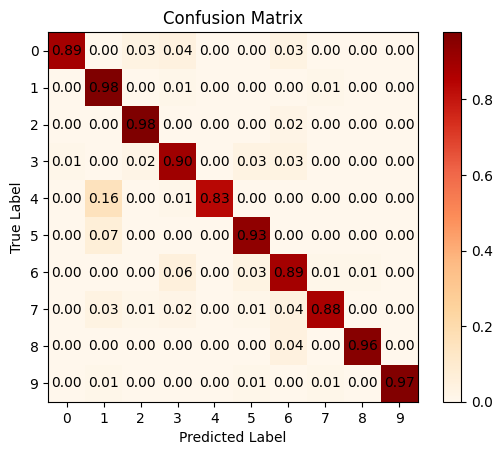

In [11]:
matrix_digits = confusion_matrix(data_test_y_digit, np.array(library_y_predictions_digits),10)
plot_conf_matrix(matrix_digits, digits)


In [12]:
print(f"The accuracy score is {accuracy_score(data_test_y_digit, np.array(library_y_predictions_digits)):.2f}")
for label in digits:
    print(f"The precision in {label} class is {precision_single(data_test_y_digit, np.array(library_y_predictions_digits), digits.index(label)):.2f}")

The accuracy score is 0.92
The precision in 0 class is 0.99
The precision in 1 class is 0.79
The precision in 2 class is 0.94
The precision in 3 class is 0.86
The precision in 4 class is 1.00
The precision in 5 class is 0.91
The precision in 6 class is 0.83
The precision in 7 class is 0.96
The precision in 8 class is 0.99
The precision in 9 class is 1.00


### *Confusion matrix for speakers*

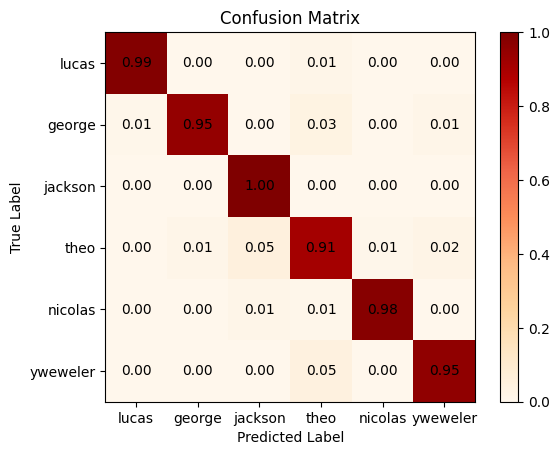

In [13]:
matrix_speakers = confusion_matrix(data_test_y_speakers, np.array(library_y_predictions_speakers),6)
plot_conf_matrix(matrix_speakers,speakers)

In [14]:
print(f"The accuracy score is {accuracy_score(data_test_y_speakers, np.array(library_y_predictions_speakers)):.2f}")
for label in speakers:
    print(f"The precision in {label} class is {precision_single(data_test_y_speakers, np.array(library_y_predictions_speakers), speakers.index(label)):.2f}")

The accuracy score is 0.96
The precision in lucas class is 0.99
The precision in george class is 0.99
The precision in jackson class is 0.94
The precision in theo class is 0.90
The precision in nicolas class is 0.99
The precision in yweweler class is 0.97


## *Implementing HMM from scratch*

In [15]:
class HMM:
    def __init__(self, num_hidden_states):
        self.num_hidden_states = num_hidden_states
        self.rand_state = np.random.RandomState(1)

        self.initial_prob = self._normalize(self.rand_state.rand(self.num_hidden_states, 1))
        self.transition_matrix = self._stochasticize(self.rand_state.rand(self.num_hidden_states, self.num_hidden_states))

        self.mean = None
        self.covariances = None
        self.num_dimensions = None

    def _forward(self, observation_matrix):
        log_likelihood = 0.
        T = observation_matrix.shape[1]
        alpha = np.zeros(observation_matrix.shape)

        for t in range(T):
            if t == 0:
                alpha[:,0] =  self.initial_prob[:,0] * observation_matrix[:,0]
            else:
                alpha[:,t] = observation_matrix[:,t] * np.matmul(self.transition_matrix.T, alpha[:,t-1])

            alpha_sum = np.sum(alpha[:, t])
            alpha[:, t] /= alpha_sum
            log_likelihood += np.log(alpha_sum)

        return log_likelihood, alpha

    def _backward(self, observation_matrix):
        T = observation_matrix.shape[1]
        beta = np.zeros(observation_matrix.shape)

        beta[:, -1] = np.ones(observation_matrix.shape[0])

        for t in range(T - 1)[::-1]:
            beta[:, t] = np.matmul(self.transition_matrix, (observation_matrix[:,t+1] * beta[:,t+1]))
            beta[:, t] /= np.sum(beta[:, t])
        return beta

    def _state_likelihood(self, obs):
        obs = np.atleast_2d(obs)
        B = np.zeros((self.num_hidden_states, obs.shape[1]))

        for s in range(self.num_hidden_states):
            np.random.seed(self.rand_state.randint(1))
            B[s, :] = multivariate_normal.pdf(obs.T,mean =self.mean[:,s],cov = self.covariances[:,:,s])

        return B

    def _normalize(self, x):
        return (x + (x == 0)) / np.sum(x)

    def _stochasticize(self, x):
        return (x + (x == 0)) / np.sum(x, axis=1)

    def _em_init(self, obs):
        if self.num_dimensions is None:
            self.num_dimensions = obs.shape[0]
        if self.mean is None:
            subset = self.rand_state.choice(np.arange(self.num_dimensions), size=self.num_hidden_states, replace=False)
            self.mean = obs[:, subset]
        if self.covariances is None:
            self.covariances = np.zeros((self.num_dimensions, self.num_dimensions, self.num_hidden_states))
            self.covariances += np.diag(np.diag(np.cov(obs)))[:, :, None]

        return self

    def _em_step(self, obs):
        obs = np.atleast_2d(obs)
        T = obs.shape[1]

        B = self._state_likelihood(obs=obs)

        log_likelihood, alpha = self._forward(B)
        beta = self._backward(B)

        xi_sum = np.zeros((self.num_hidden_states, self.num_hidden_states))
        gamma = np.zeros((self.num_hidden_states, T))

        for t in range(T - 1):
            partial_sum = sum(alpha[:,t] * beta[:,t+1] * B[:,t+1]) * self.transition_matrix
            xi_sum += self._normalize(partial_sum)
            partial_g = alpha[:,t] * beta[:,t]
            gamma[:, t] = self._normalize(partial_g)

        partial_g = alpha[:,T-1] * beta[:,T-1]
        gamma[:, -1] = self._normalize(partial_g)

        expected_prior = np.reshape(gamma[:, 0],(-1,1))
        expected_transition = self._stochasticize(xi_sum/np.sum(xi_sum,axis=(0,1)))

        expected_covariances = np.zeros((self.num_dimensions, self.num_dimensions, self.num_hidden_states))
        expected_covariances += .01 * np.eye(self.num_dimensions)[:, :, None]

        gamma_state_sum = np.sum(gamma, axis=1)
        gamma_state_sum = gamma_state_sum + (gamma_state_sum == 0)

        expected_mean = np.zeros((self.num_dimensions, self.num_hidden_states))
        for s in range(self.num_hidden_states):
            gamma_obs = obs * gamma[s, :]
            expected_mean[:, s] = np.sum(gamma_obs, axis=1) / gamma_state_sum[s]

        self.initial_prob = expected_prior
        self.mean = expected_mean
        self.covariances = expected_covariances
        self.transition_matrix = expected_transition

        return log_likelihood

    def train(self, obs, num_iterations=1):
        for i in range(num_iterations):
            self._em_init(obs)
            self._em_step(obs)
        return self

    def score(self, obs):
        B = self._state_likelihood(obs)
        log_likelihood, _ = self._forward(B)
        return log_likelihood


### *for digits:*

In [16]:
digit_HMM_models = []

for label in digits:
    model = HMM(num_hidden_states=12)
    model.train(DS_train_digits[label].T/np.amax(DS_train_digits[label].T),num_iterations=7)
    digit_HMM_models.append(model)

y_preds_scratch_digits=[]
for i in range(data_test_x_digit.shape[0]):
    scores=[]
    for model in digit_HMM_models:
        scores.append(model.score(data_test_x_digit[i,:].T/np.amax(data_test_x_digit[i,:].T)))
    label = np.argmax(np.array(scores))
    y_preds_scratch_digits.append(label)

C:\Users\Maryam\AppData\Local\Temp\ipykernel_13716\1943663167.py:25: RuntimeWarning: invalid value encountered in divide
  alpha[:, t] /= alpha_sum
C:\Users\Maryam\AppData\Local\Temp\ipykernel_13716\1943663167.py:26: RuntimeWarning: divide by zero encountered in log
  log_likelihood += np.log(alpha_sum)


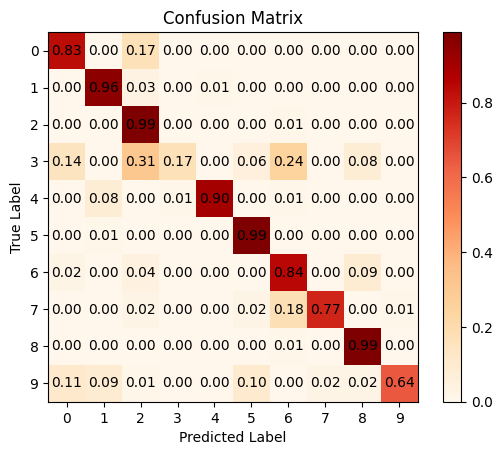

In [17]:
matrix_scratch_digits = confusion_matrix(data_test_y_digit, np.array(y_preds_scratch_digits),10)
plot_conf_matrix(matrix_scratch_digits,digits)

### *for speakers:*

In [18]:
speakers_HMM_models = []

for label in speakers:
    model = HMM(num_hidden_states=12)
    model.train(DS_train_speakers[label].T/np.amax(DS_train_speakers[label].T),num_iterations=10)
    speakers_HMM_models.append(model)

y_preds_scratch_speakers=[]
for i in range(data_test_x_speakers.shape[0]):
    scores=[]
    for model in speakers_HMM_models:
        scores.append(model.score(data_test_x_speakers[i,:].T/np.amax(data_test_x_speakers[i,:].T)))
    label = np.argmax(np.array(scores))
    y_preds_scratch_speakers.append(label)

C:\Users\Maryam\AppData\Local\Temp\ipykernel_13716\1943663167.py:25: RuntimeWarning: invalid value encountered in divide
  alpha[:, t] /= alpha_sum
C:\Users\Maryam\AppData\Local\Temp\ipykernel_13716\1943663167.py:26: RuntimeWarning: divide by zero encountered in log
  log_likelihood += np.log(alpha_sum)


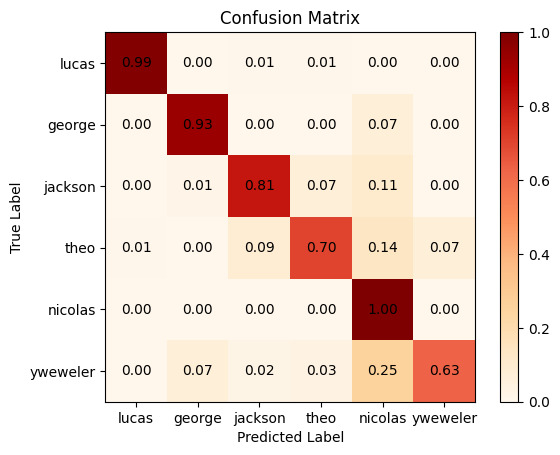

In [19]:
matrix_scratch_speakers = confusion_matrix(data_test_y_speakers, np.array(y_preds_scratch_speakers),6)
plot_conf_matrix(matrix_scratch_speakers,speakers)

In [20]:
print(f"The accuracy is {accuracy_score(data_test_y_digit, np.array(y_preds_scratch_digits)):.2f}")
for label in digits:
    print(f"The precision in {label} class is {precision_single(data_test_y_digit, np.array(y_preds_scratch_digits), digits.index(label)):.2f}")

The accuracy is 0.81
The precision in 0 class is 0.75
The precision in 1 class is 0.84
The precision in 2 class is 0.63
The precision in 3 class is 0.94
The precision in 4 class is 0.99
The precision in 5 class is 0.85
The precision in 6 class is 0.65
The precision in 7 class is 0.97
The precision in 8 class is 0.84
The precision in 9 class is 0.98


In [21]:
print(f"The accuracy is {accuracy_score(data_test_y_speakers, np.array(y_preds_scratch_speakers)):.2f}")
for label in speakers:
    print(f"The precision in {label} class is {precision_single(data_test_y_speakers, np.array(y_preds_scratch_speakers), speakers.index(label)):.2f}")

The accuracy is 0.84
The precision in lucas class is 0.99
The precision in george class is 0.92
The precision in jackson class is 0.88
The precision in theo class is 0.87
The precision in nicolas class is 0.64
The precision in yweweler class is 0.90


## *Evaluation and Analysis*

### *Question 1:*
-  *Accuracy: Accuracy measures the overall correctness of the model predictions. it is calculated as the ratio of the number of correct predictions to the total number of data. it can be misleading when there is an imbalanced dataset. The formula for accuracy is:*

$$\ \text{Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Number of Predictions}} =\frac{\text{True Positive} + \text{True Negative}}{\text{True Positive} + \text{True Negative} + \text{False Positive} + \text{False Negative}} \$$
<br>



- *Precision: it measures the proportion of positive predictions made by the model that are actually correct and true. it is calculated as the ratio of true positives to the sum of true positives and false positives. precision is useful when the cost of false positives is high. Precision is defined as:*

$$ \text{Precision} = \frac{\text{True Positives}}{\text{True Positives + False Positives}} \$$

<br>



- *Recall: Recall, also known as sensitivity or true positive rate, is a metric used in the evaluation of classification models, particularly in binary classification problems. Recall measures the ability of a model to capture all the relevant instances of a positive class. It is defined as:*

$$ \text{Recall} = \frac{\text{True Positives}}{\text{True Positives + False Negatives}} \$$

<br>



- *F1 score: It is a harmonic mean of precision and recall providing a metric that balances both of them. it is useful when there is an imbalance between the positive and negative dataclasses.*

$$ \text{F1 score} = \frac{2 \times (\text{Precision} \times \text{Recall})}{\text{Precision} + \text{Recall}} $$



### *Question 2:*
*For multi-class projects, calculating metrics such as F1-score, recall, precision, and accuracy can pose challenges due to several factors:*

1. *Class Imbalance: Imbalanced class distributions can affect the reliability of these metrics. The presence of significantly more instances of one class compared to others may skew the evaluation results.*

2. *Class Importance: Some classes may be more important than others in the context of the problem. In such cases, metrics like recall or precision for specific classes might be more relevant but could be overshadowed by the overall metrics.*

3. *Accuracy's Limitations: Accuracy alone may not adequately represent the model's performance, especially when classes are imbalanced. High accuracy can sometimes mask the model's poor performance on minority classes.*

*To address these challenges, several strategies can be employed:*

- *Alternative Metrics: Using alternative metrics such as F1-score, which considers both precision and recall, or confusion matrices can provide a more comprehensive evaluation of the model's performance across multiple classes.*

- *Class Balancing: Employ techniques like oversampling or undersampling to balance class distributions, ensuring that each class has a similar number of instances in the evaluation dataset.*

- *Class-Weighted Approaches: Assigning different weights to classes based on their importance can ensure that the evaluation metrics properly account for the significance of each class in the problem domain.*

*By implementing these solutions, we can enhance the evaluation process for multi-class projects and obtain more informative insights into the model's performance.*

### *Question 3:*

1. *Accuracy: This is the simplest and most intuitive metric. It's the ratio of correct predictions to the total number of predictions. In other words, it's the proportion of instances that the model classified correctly. However, accuracy can be misleading if the classes are imbalanced. For example, if 95% of your data is of one class, a model that always predicts this class will have 95% accuracy, but it's not a good model.*

2. *Precision: Precision measures the quality of your positive predictions. It's the ratio of true positives (correctly predicted positives) to all predicted positives (both correctly and incorrectly predicted). It answers the question: "Of all the instances the model labeled as positive, how many are actually positive?"*

3. *Recall: Also known as sensitivity or true positive rate, recall measures the ability of a model to find all the positive instances. It's the ratio of true positives to all actual positives (both correctly predicted and missed). It answers the question: "Of all the actual positive instances, how many did the model correctly identify?"*

4. *F1-score: The F1-score is the harmonic mean of precision and recall. While precision and recall are informative, looking at only one of them could give you an incomplete picture of your model's performance. The F1-score combines them into a single number, which is high only if both precision and recall are high. This makes it a good metric to use if you want to balance precision and recall and there's no clear preference between the two.*

### *Question 4:*
*Recall: A high recall indicates that the model is effective in capturing most of the positive instances; however, it may result in a higher number of false positives, which can be costly in certain applications.*

*Precision: High precision implies that the model is accurate in identifying positive instances, but it might miss some relevant instances, leading to a lower recall.*

*Example:*

*Consider a medical diagnostic model designed to identify patients with a rare disease. Let's say the prevalence of the disease is very low, and only 1 out of 1,000 individuals has the disease.*

*The model predicts 10 individuals as positive cases. Out of these 10, only 1 individual actually has the disease (True Positive), while the other 9 are false positives. The model correctly identifies the one positive case, resulting in high precision (1/10 = 0.1), but the recall is extremely low (1/1 = 1).*

*In this example, although precision is high, the model is not effectively capturing all the positive cases, and the low recall indicates that it may not be suitable for practical use. This illustrates why considering both recall and precision together, often in the form of the F1 score or the Receiver Operating Characteristic (ROC) curve, provides a more comprehensive evaluation of the model's performance.*

### *Question 5:*
*The F1 score uses the harmonic mean, which is less sensitive to extreme values, making it suitable for skewed distributions or datasets with rates and ratios. This helps counter the impact of imbalanced data distributions in F1 score calculations.*

### *Question 6:*
*in part in which we used libraries, we could see a better result than implemention from scratch.it's often hard to match the performance of established libraries. the difference is obvious in class 3. we can improve second implementation by increasing the number of iterations.*

### *Question 7:*
*in part in which we used libraries, we could see a better result than implemention from scratch.it's often hard to match the performance of established libraries. the difference is obvious in some classes. we can improve second implementation by increasing the number of iterations.*

### *Question 8:*
*The difference in performance between speaker recognition model and digit recognition model could be beacuse of the characteristics of the data used for training can greatly influence the performance of the models. The speaker recognition task might be easier if the speakers have distinct voices, while the digit recognition task could be more challenging if the same digit is pronounced differently by different speakers.since the datases have balanced classes, i.e., each speaker or digit is equally represented, this can prevent the model from being biased towards any particular class and improve overall accuracy.that's why the diffrenece wasn't that much betweeen the two models.*


